In [1]:
import numpy as np
import pandas as pd

In [2]:
sc

<SparkContext master=local[3] appName=PySparkShell>

# Prepare Data for Modeling

## Duplicates

In [3]:
df = spark.createDataFrame([
 (1, 144.5, 5.9, 33, 'M'),
 (2, 167.2, 5.4, 45, 'M'),
 (3, 124.1, 5.2, 23, 'F'),
 (4, 144.5, 5.9, 33, 'M'),
 (5, 133.2, 5.7, 54, 'F'),
 (3, 124.1, 5.2, 23, 'F'),
 (5, 129.2, 5.3, 42, 'M'),
 ], schema= ['id', 'weight', 'height', 'age', 'gender'])

In [4]:
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  1| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  4| 144.5|   5.9| 33|     M|
|  5| 133.2|   5.7| 54|     F|
|  3| 124.1|   5.2| 23|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



Check pure duplicates:

In [5]:
print('Count of rows: {0}'.format(df.count()))
print('Count of distinct rows: {0}'.format(df.distinct().count()))

Count of rows: 7
Count of distinct rows: 6


In [6]:
df = df.dropDuplicates()

In [7]:
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  5| 129.2|   5.3| 42|     M|
|  1| 144.5|   5.9| 33|     M|
|  4| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
+---+------+------+---+------+



Check duplicates (other than ID):

In [8]:
print('Counts of IDs: {0}'.format(df.count()))
print('Counts of distinct IDs: {0}'.format(
    df.select([
        c for c in df.columns if c != 'id'
    ]).distinct().count()
))

Counts of IDs: 6
Counts of distinct IDs: 5


In [9]:
df = df.dropDuplicates(
    subset= [c for c in df.columns if c != 'id']
)

In [10]:
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  1| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



Duplicated IDs:

In [11]:
import pyspark.sql.functions as fn

In [12]:
df.agg(
    fn.count('id').alias('count'),
    fn.countDistinct('id').alias('distinct')
).show()

+-----+--------+
|count|distinct|
+-----+--------+
|    5|       4|
+-----+--------+



Since we have
already dropped all the duplicates, we can safely assume that this might just be a
fluke in our ID data, so we will give each row a unique ID:

In [13]:
df.withColumn('new_id', 
              fn.monotonically_increasing_id()).show()

+---+------+------+---+------+-------------+
| id|weight|height|age|gender|       new_id|
+---+------+------+---+------+-------------+
|  5| 133.2|   5.7| 54|     F|  25769803776|
|  1| 144.5|   5.9| 33|     M| 171798691840|
|  2| 167.2|   5.4| 45|     M| 592705486848|
|  3| 124.1|   5.2| 23|     F|1236950581248|
|  5| 129.2|   5.3| 42|     M|1365799600128|
+---+------+------+---+------+-------------+



In [14]:
df = df.withColumn('id', 
              fn.monotonically_increasing_id())

## Missing observations

- If your data is a discrete Boolean, you can turn it into a categorical variable by adding a third category — Missing
- If your data is already categorical, you can simply extend the number of levels and add the Missing category as well
- If you're dealing with ordinal or numerical data, you can impute either mean, median, or some other predefined value (for example, first or third quartile, depending on the distribution shape of your data)

In [15]:
df_miss = spark.createDataFrame([
 (1, 143.5, 5.6, 28, 'M', 100000),
 (2, 167.2, 5.4, 45, 'M', None),
 (3, None , 5.2, None, None, None),
 (4, 144.5, 5.9, 33, 'M', None),
 (5, 133.2, 5.7, 54, 'F', None),
 (6, 124.1, 5.2, None, 'F', None),
 (7, 129.2, 5.3, 42, 'M', 76000),
 ], ['id', 'weight', 'height', 'age', 'gender', 'income'])

In [16]:
df_miss.show()

+---+------+------+----+------+------+
| id|weight|height| age|gender|income|
+---+------+------+----+------+------+
|  1| 143.5|   5.6|  28|     M|100000|
|  2| 167.2|   5.4|  45|     M|  null|
|  3|  null|   5.2|null|  null|  null|
|  4| 144.5|   5.9|  33|     M|  null|
|  5| 133.2|   5.7|  54|     F|  null|
|  6| 124.1|   5.2|null|     F|  null|
|  7| 129.2|   5.3|  42|     M| 76000|
+---+------+------+----+------+------+



Find the frequency of missing values by column:

In [17]:
df_miss.agg(*[
    (1 - (fn.count(c)/fn.count('*'))).alias(c + '_missing')
    for c in df_miss.columns
]).show()

+----------+------------------+--------------+------------------+------------------+------------------+
|id_missing|    weight_missing|height_missing|       age_missing|    gender_missing|    income_missing|
+----------+------------------+--------------+------------------+------------------+------------------+
|       0.0|0.1428571428571429|           0.0|0.2857142857142857|0.1428571428571429|0.7142857142857143|
+----------+------------------+--------------+------------------+------------------+------------------+



Remove columns with more than 50% of missing values:

In [18]:
df_miss_no_income = df_miss.select([
    c for c in df_miss.columns if c != 'income' 
])

In [19]:
df_miss_no_income.show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  3|  null|   5.2|null|  null|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



Find the frequency of missing values by row:

In [20]:
df_miss_no_income.rdd.map(
    lambda row: (row.id, sum([c == None for c in row])/len(row))
).collect()

[(1, 0.0), (2, 0.0), (3, 0.6), (4, 0.0), (5, 0.0), (6, 0.2), (7, 0.0)]

Option 1) Drop rows that has more than 50% of missing values:

In [21]:
df_miss_no_income.rdd.filter(
    lambda row: (sum([c == None for c in row])/len(row) < 0.5) 
).toDF().show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



Option 2) Impute observations:

In [22]:
means = df_miss_no_income.agg(*[
    fn.mean(c).alias(c)
    for c in df_miss_no_income.columns if c != 'gender'
]).toPandas().to_dict('records')[0]

In [23]:
means

{'id': 4.0,
 'weight': 140.28333333333333,
 'height': 5.471428571428571,
 'age': 40.4}

In [24]:
means['gender'] = 'missing'

In [25]:
df_miss_no_income.fillna(means).show()

+---+------------------+------+---+-------+
| id|            weight|height|age| gender|
+---+------------------+------+---+-------+
|  1|             143.5|   5.6| 28|      M|
|  2|             167.2|   5.4| 45|      M|
|  3|140.28333333333333|   5.2| 40|missing|
|  4|             144.5|   5.9| 33|      M|
|  5|             133.2|   5.7| 54|      F|
|  6|             124.1|   5.2| 40|      F|
|  7|             129.2|   5.3| 42|      M|
+---+------------------+------+---+-------+



## Outliers

Outliers are those observations that deviate significantly from the distribution of
the rest of your sample.

The definitions of significance vary, but in the most general
form, you can accept that there are no outliers if all the values are roughly within
the <b>Q1−1.5IQR</b> and <b>Q3+1.5IQR</b> range, where IQR is the interquartile range; the IQR
is defined as a difference between the upper- and lower-quartiles, that is, the 75th
percentile (the Q3) and 25th percentile (the Q1), respectively.

In [26]:
df_outliers = spark.createDataFrame([
 (1, 143.5, 5.3, 28),
 (2, 154.2, 5.5, 45),
 (3, 342.3, 5.1, 99),
 (4, 144.5, 5.5, 33),
 (5, 133.2, 5.4, 54),
 (6, 124.1, 5.1, 21),
 (7, 129.2, 5.3, 42),
 ], ['id', 'weight', 'height', 'age'])

In [27]:
cols = ['weight', 'height', 'age']
bounds = {}

In [28]:
for col in cols:
    quantiles = df_outliers.approxQuantile(
        col= col, probabilities = [0.25, 0.74],
        relativeError = 0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [
        quantiles[0] - 1.5 * IQR,
        quantiles[1] + 1.5 * IQR
    ]

In [29]:
bounds

{'weight': [91.69999999999999, 191.7],
 'height': [4.499999999999999, 6.1000000000000005],
 'age': [-11.0, 93.0]}

Flag outliers:

In [30]:
df_outliers.show()

+---+------+------+---+
| id|weight|height|age|
+---+------+------+---+
|  1| 143.5|   5.3| 28|
|  2| 154.2|   5.5| 45|
|  3| 342.3|   5.1| 99|
|  4| 144.5|   5.5| 33|
|  5| 133.2|   5.4| 54|
|  6| 124.1|   5.1| 21|
|  7| 129.2|   5.3| 42|
+---+------+------+---+



In [31]:
outliers = df_outliers.select(*['id'] + [
 (
 (df_outliers[c] < bounds[c][0]) |
 (df_outliers[c] > bounds[c][1])
 ).alias(c + '_o') for c in cols
])
outliers.show()

+---+--------+--------+-----+
| id|weight_o|height_o|age_o|
+---+--------+--------+-----+
|  1|   false|   false|false|
|  2|   false|   false|false|
|  3|    true|   false| true|
|  4|   false|   false|false|
|  5|   false|   false|false|
|  6|   false|   false|false|
|  7|   false|   false|false|
+---+--------+--------+-----+



Removing outliers:

In [32]:
df_outliers = df_outliers.join(outliers, on='id')

In [33]:
df_outliers = df_outliers.filter(
    df_outliers['weight_o'] == False
).filter(
    df_outliers['height_o'] == False
).filter(
    df_outliers['age_o'] == False
).select(*['id'] + cols)

In [34]:
df_outliers.show()

+---+------+------+---+
| id|weight|height|age|
+---+------+------+---+
|  7| 129.2|   5.3| 42|
|  6| 124.1|   5.1| 21|
|  5| 133.2|   5.4| 54|
|  1| 143.5|   5.3| 28|
|  2| 154.2|   5.5| 45|
|  4| 144.5|   5.5| 33|
+---+------+------+---+



## Getting familiar with data

In [35]:
import pyspark.sql.types as typ

In [36]:
path_fraud = './data/ccFraud.csv'

In [37]:
df_ccfraud = spark.read.csv(path= path_fraud,
                           inferSchema = True,
                           sep = ',',
                           header = True)

In [38]:
df_ccfraud.show(5)

+------+------+-----+----------+-------+--------+------------+----------+---------+
|custID|gender|state|cardholder|balance|numTrans|numIntlTrans|creditLine|fraudRisk|
+------+------+-----+----------+-------+--------+------------+----------+---------+
|     1|     1|   35|         1|   3000|       4|          14|         2|        0|
|     2|     2|    2|         1|      0|       9|           0|        18|        0|
|     3|     2|    2|         1|      0|      27|           9|        16|        0|
|     4|     1|   15|         1|      0|      12|           0|         5|        0|
|     5|     1|   46|         1|      0|      11|          16|         7|        0|
+------+------+-----+----------+-------+--------+------------+----------+---------+
only showing top 5 rows



Descriptive analysis:

In [39]:
df_ccfraud.printSchema()

root
 |-- custID: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- cardholder: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- numTrans: integer (nullable = true)
 |-- numIntlTrans: integer (nullable = true)
 |-- creditLine: integer (nullable = true)
 |-- fraudRisk: integer (nullable = true)



In [40]:
df_ccfraud.groupby('gender').count().show()

+------+-------+
|gender|  count|
+------+-------+
|     1|6178231|
|     2|3821769|
+------+-------+



In [41]:
numeric = ['balance', 'numTrans',
           'numIntlTrans']
df_ccfraud.select(*numeric).describe().show()

+-------+----------------+------------------+-----------------+
|summary|         balance|          numTrans|     numIntlTrans|
+-------+----------------+------------------+-----------------+
|  count|        10000000|          10000000|         10000000|
|   mean|    4109.9199193|        28.9351871|        4.0471899|
| stddev|3996.84730973732|26.553781024522937|8.602970115864021|
|    min|               0|                 0|                0|
|    max|           41485|               100|               60|
+-------+----------------+------------------+-----------------+



Skeweness (symmetry):

In [42]:
df_ccfraud.agg({'balance': 'skewness'}).show()

+------------------+
| skewness(balance)|
+------------------+
|1.1818315552993286|
+------------------+



- Se v>0, então a distribuição tem uma cauda direita (valores acima da média) mais pesada
- Se v<0, então a distribuição tem uma cauda esquerda (valores abaixo da média) mais pesada
- Se v=0, então a distribuição é aproximadamente simétrica (na terceira potência do desvio em relação à média).

Correlations:

The model should normally include only those features that are highly correlated with your target. However, it is almost equally important to check the correlation between the features; including features that are highly correlated among them (that is, are collinear) may lead to unpredictable behavior of your model, or
might unnecessarily complicate it.

In [43]:
df_ccfraud.corr('balance', 'numTrans')

0.00044523140172652816

In [44]:
corr_matrix = []
for i in numeric:
    row = []
    for j in numeric:
        row.append(df_ccfraud.corr(i, j))
    corr_matrix.append(row)

corr_df = pd.DataFrame(corr_matrix,
                       columns=numeric,
                       index= numeric)

In [45]:
corr_df

,balance,numTrans,numIntlTrans
balance,1.000000,0.000445,0.000271
numTrans,0.000445,1.000000,-0.000281
numIntlTrans,0.000271,-0.000281,1.000000


The correlations between the numerical features in the credit card
fraud dataset are pretty much non-existent. Thus, all these features can be used in
our models, should they turn out to be statistically sound in explaining our target.

## Visualization

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import bokeh.plotting as chrt
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

Histograms:

There are three ways you can generate histograms in PySpark (or a Jupyter
notebook):
- Aggregate the data in workers and return an aggregated list of bins and counts in each bin of the histogram to the driver;
- Return all the data points to the driver and allow the plotting libraries' methods to do the job for you;
- Sample your data and then return them to the driver for plotting.

1) Aggregating data:

In [47]:
hists = df_ccfraud.select('balance').rdd.flatMap(
 lambda row: row
).histogram(20)

In [48]:
data = {
    'bins': hists[0][:-1],
    'freq': hists[1]
}

Text(0.5,1,"Histogram of 'balance'")

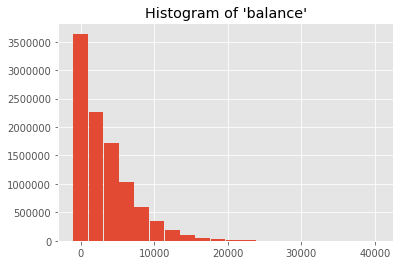

In [49]:
plt.bar(data['bins'], data['freq'], width=2000)
plt.title("Histogram of 'balance'")

2) Data from driver:

OBS: If your data is small enough to fit on the driver (although we would argue it would normally be faster to use the previous method), you can bring the data without any major problems.

In [ ]:
data_driver = {
 'obs': df_ccfraud.select('balance').rdd.map(
 lambda row: row
 ).collect()
}

In [ ]:
plt.hist(data_driver['obs'], bins=20)
plt.title('Histogram of \'balance\' from driver')

## Interactions between features

Since PySpark does not offer any visualization modules on the server side, and
trying to plot billions of observations at the same time would be highly impractical,
in this section we will sample the dataset at 0.02% (roughly 2,000 observations).

In [50]:
data_sample = df_ccfraud.sampleBy(
    'gender', {1: 0.0002, 2: 0.0002}
).select('*')

In [51]:
data_sample = data_sample.toPandas()

In [189]:
unique = data_sample['gender'].unique()

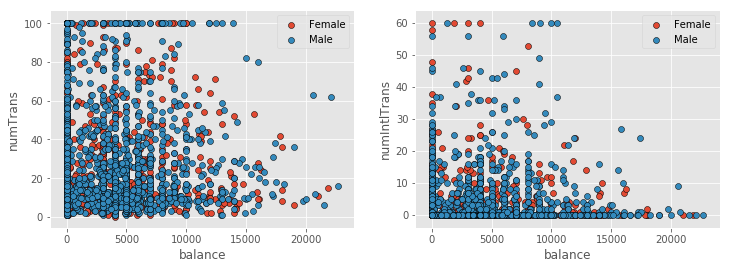

In [188]:
fig, ax = plt.subplots(figsize = (12,4), nrows=1, ncols=2)
for i, col in enumerate(numeric[1:]):
    for un in unique:
        ax[i].scatter(data_sample['balance'].loc[data_sample['gender'] == un],
                data_sample[col].loc[data_sample['gender'] == un],
                label = 'Female' if un == 2 else 'Male', edgecolor='k')
    ax[i].set_xlabel('balance')
    ax[i].set_ylabel(col)
    ax[i].legend()